In [33]:
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from skimage.metrics import mean_squared_error
import matplotlib.pyplot as plt

## Preparacion de datos

In [4]:
centro_22_23 = pd.read_excel("DATOS HISTÓRICOS 2022_2023_TODAS ESTACIONES.xlsx", sheet_name = "CENTRO")
centro_22_23.head()

,date,CO,NO,NO2,NOX,O3,PM10,PM2.5,PRS,RAINF,RH,SO2,SR,TOUT,WSR,WDR
0,2022-01-01 00:00:00,2.60,3.5,44.9,48.5,15.0,134.0,91.00,705.5,0.0,46.0,5.3,0.0,21.37,3.4,267.0
1,2022-01-01 01:00:00,2.23,2.9,32.9,36.0,19.0,141.0,112.61,705.2,0.0,48.0,6.1,0.0,20.83,3.3,259.0
2,2022-01-01 02:00:00,1.99,2.9,27.6,30.7,21.0,117.0,92.46,705.1,0.0,46.0,5.8,0.0,20.52,5.9,233.0
3,2022-01-01 03:00:00,2.03,NaN,NaN,NaN,18.0,108.0,69.20,704.8,0.0,46.0,6.0,0.0,20.12,5.1,220.0
4,2022-01-01 04:00:00,1.86,NaN,NaN,NaN,20.0,106.0,68.03,704.8,0.0,46.0,5.6,0.0,19.85,4.7,244.0


In [5]:
print(centro_22_23.shape)
centro_22_23.columns

(14255, 16)


Index(['date', 'CO', 'NO', 'NO2', 'NOX', 'O3', 'PM10', 'PM2.5', 'PRS', 'RAINF',
       'RH', 'SO2', 'SR', 'TOUT', 'WSR', 'WDR'],
      dtype='object')

In [6]:
centro_22_23.isna().sum().sum()

6136

In [9]:
df_23_24 = pd.read_excel("DATOS HISTÓRICOS 2023_2024_TODAS ESTACIONES_ITESM.xlsx")
df_23_24.head()

,Unnamed: 0,SURESTE,SURESTE.1,SURESTE.2,SURESTE.3,SURESTE.4,SURESTE.5,SURESTE.6,SURESTE.7,SURESTE.8,...,NOROESTE 3.5,NOROESTE 3.6,NOROESTE 3.7,NOROESTE 3.8,NOROESTE 3.9,NOROESTE 3.10,NOROESTE 3.11,NOROESTE 3.12,NOROESTE 3.13,NOROESTE 3.14
0,NaN,CO,NO,NO2,NOX,O3,PM10,PM2.5,PRS,RAINF,...,PM10,PM2.5,PRS,RAINF,RH,SO2,SR,TOUT,WSR,WDR
1,date,ppm,ppb,ppb,ppb,ppb,ug/m3,ug/m3,mmhg,mm/hr,...,ug/m3,ug/m3,mmhg,mm/hr,%,ppb,KW/m2,degC,KMPH,DEG
2,2023-01-01 00:00:00,2.37,54.5,32.6,87.1,3,110,68,721.7,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-01-01 01:00:00,2.12,38.7,30.3,68.9,3,116,67.18,721.5,0,...,246,NaN,707.4,0,59,2.9,0,14.14,65.3,95
4,2023-01-01 02:00:00,2.05,38.7,28.8,67.4,3,117,75.12,721.1,0,...,239,NaN,707,0,59,3.2,0,14.11,60.9,90


Para el dataframe de 2023-2024, dado que cuenta con un formato distinto se tienen que hacer algunas funciones:

In [8]:
def drop_unnamed_columns(df):
    """
    Elimina columnas cuyo nombre contiene 'Unnamed: '.
    
    Parameters:
        df (pd.DataFrame): El DataFrame de entrada.
    
    Returns:
        pd.DataFrame: Un nuevo DataFrame sin las columnas que contienen 'Unnamed: '.
    """
    # Filtrar las columnas que contienen "Unnamed: " y eliminarlas
    return df.drop(columns=[col for col in df.columns if "Unnamed: " in col])


def preparar_df_23_24(df, region):
    """
    Prepara los dataframes del excel 'DATOS HISTÓRICOS 2023_2024_TODAS ESTACIONES_ITESM.xlsx'
    dado que estos cuentan con un formato distinto.

    Args:
        df (pd.dataframe): dataframe 2023_2024
        region (str): region de interes

    Returns:
        pd.dataframe: dataframe preparado para limpieza
    """
    columna_fecha = df["Unnamed: 0"]
    columna_fecha = columna_fecha.dropna() #quitar espacios vacios
    columna_fecha = columna_fecha.iloc[1:] # acceder solo a las fechas
    columna_fecha = columna_fecha.reset_index(drop=True) # indice desde 0
    
    df_preparado = df.copy()
    df_preparado = df_preparado.filter(regex=f'^({region}$|{region}\\.|Unnamed)') #Filtrar por region
    df_preparado_copy = df_preparado.copy()
    df_preparado = drop_unnamed_columns(df_preparado_copy) #Quitar columnas "Unnamed"
    
    # Reemplazar nombres de columnas con primera fila
    df_preparado.columns = df_preparado.iloc[0,:]
    # Quitar segundo renglon (unidades)
    df_preparado = df_preparado.iloc[2:].reset_index(drop=True)
    # Renombrar columna de dirección del viento para que coincida con el dataset 2022-2023
    df_preparado = df_preparado.rename(columns={'WDV': 'WDR'})
    # Pegar columna de fecha al inicio
    df_preparado.insert(0, 'date', columna_fecha)
    
    return df_preparado

In [14]:
centro_23_24_original = preparar_df_23_24(df_23_24, region = "CENTRO")
centro_23_24_original.head()

,date,CO,NO,NO2,NOX,O3,PM10,PM2.5,PRS,RAINF,RH,SO2,SR,TOUT,WSR,WDR
0,2023-01-01 00:00:00,1.67,4.1,30.3,34.5,9,118,94.12,718.4,0,45,3.3,0,17.65,4.9,236
1,2023-01-01 01:00:00,1.7,5,28.9,34.1,9,97,96.79,710.7,0,47,3.4,0.001,17.12,3.4,336
2,2023-01-01 02:00:00,1.51,4.3,23.2,27.7,11,103,81.23,710.4,0,46,3.4,0.001,16.69,3.4,3
3,2023-01-01 03:00:00,1.3,3.8,20.9,24.9,11,83,49.83,710.1,0,48,3.2,0.001,15.99,2.6,315
4,2023-01-01 04:00:00,1.28,4.6,20.7,25.5,9,65,40.19,710.2,0,55,3,0.001,14.74,3.9,270


In [13]:
centro_22_23.tail(1)

,date,CO,NO,NO2,NOX,O3,PM10,PM2.5,PRS,RAINF,RH,SO2,SR,TOUT,WSR,WDR
14254,2023-08-17 23:00:00,0.61,2.5,6.2,8.9,31.0,48.0,11.39,710.6,0.0,37.0,2.5,0.0,31.95,12.7,94.0


Antes de concatenar las bases, se tienen que eliminar las filas que se repiten. La ultima fecha en los datasets de 22-23 es 2023-08-17 23:00:00, por lo tanto quitaremos esta fecha en y todas las anteriores en el dataset de 23_24

In [17]:
centro_23_24 = centro_23_24_original[centro_23_24_original['date'] > '2023-08-17 23:00:00']
centro_23_24.head()

,date,CO,NO,NO2,NOX,O3,PM10,PM2.5,PRS,RAINF,RH,SO2,SR,TOUT,WSR,WDR
5495,2023-08-18 00:00:00,0.59,2.4,7.2,9.8,27,61,11.99,710.7,0,45,2.5,0,30.38,13.8,73
5496,2023-08-18 01:00:00,0.57,2.5,5.7,8.4,28,62,10.06,710.7,0,41,3,0,29.96,7.9,85
5497,2023-08-18 02:00:00,0.55,2.3,3.7,6.2,31,44,8.34,710.5,0,43,2.7,0,29.07,8.3,68
5498,2023-08-18 03:00:00,0.53,2.3,4.6,7.1,28,41,9.69,710.5,0,49,2.4,0,27.7,9,45
5499,2023-08-18 04:00:00,0.52,4.9,16.6,21.8,14,52,12.1,710.5,0,54,2.5,0,26.58,7.3,21


In [19]:
print(centro_22_23.shape)
print(centro_23_24.shape)

(14255, 16)
(8375, 16)


In [22]:
centro = pd.concat([centro_22_23, centro_23_24], axis = 0, ignore_index = True)
centro.shape

(22630, 16)

In [25]:
#verificar que se concatenaron de manera adecuada
centro.iloc[14254:, :].round(3).head()

,date,CO,NO,NO2,NOX,O3,PM10,PM2.5,PRS,RAINF,RH,SO2,SR,TOUT,WSR,WDR
14254,2023-08-17 23:00:00,0.61,2.5,6.2,8.9,31.0,48.0,11.39,710.6,0.0,37.0,2.5,0.0,31.95,12.7,94.0
14255,2023-08-18 00:00:00,0.59,2.4,7.2,9.8,27,61,11.99,710.7,0,45,2.5,0,30.38,13.8,73
14256,2023-08-18 01:00:00,0.57,2.5,5.7,8.4,28,62,10.06,710.7,0,41,3,0,29.96,7.9,85
14257,2023-08-18 02:00:00,0.55,2.3,3.7,6.2,31,44,8.34,710.5,0,43,2.7,0,29.07,8.3,68
14258,2023-08-18 03:00:00,0.53,2.3,4.6,7.1,28,41,9.69,710.5,0,49,2.4,0,27.7,9,45


## Limpieza

### Manejo de duplicados

In [29]:
print("Numero de filas duplicadas:", centro.duplicated().sum())

Numero de filas duplicadas: 0


### Manejo de datos erroneos (fuera de rango)

In [27]:
def limpiar_datos_erroneos(df):
    """
    Anula datos fuera de los rangos de valores válidos para cada columna
    (valores fuera de este rango probablemente son incorrectos)
    
    Args:
        - df (pd.dataframe): dataframe con datos de contaminantes
    
    Returns:
        - pd.dataframe: dataframe sin datos erroneos
    """
    
    rangos_validos = {
        'CO': [0, 35],
        'NO': [0, 1000],
        'NO2': [0, 400],
        'NOX': [0, 1000],
        'O3': [0, 400],
        'PM2.5': [0, 500],
        'PM10': [0, 1500],
        'PRS': [0, 800],
        'RAINF': [0, 350],
        'RH': [0, 100],
        'SO2': [0, 500],
        'SR': [0, 1.5],
        'TOUT': [-20, 50],
        'WSR': [0, 150],
        'WDR': [0, 360]
    }
    
    # Iterar sobre cada columna y aplicar los rangos válidos
    for columna, rango in rangos_validos.items():
        df.loc[(df[columna] < rango[0]) | (df[columna] > rango[1]), columna] = np.nan
    return df

In [28]:
print(centro.isna().sum().sum())
centro = limpiar_datos_erroneos(centro)
print(centro.isna().sum().sum())

11762
11762


Afortunadamente para esta ocasion no habia datos fuera de los rangos esperados.

### Manejo de datos faltantes (imputacion)

In [32]:
print("Desglose de datos nulos por columna:")
centro.isna().sum()

Desglose de datos nulos por columna:


date        0
CO        475
NO       1270
NO2       487
NOX       486
O3        868
PM10      540
PM2.5    3412
PRS       450
RAINF     417
RH        563
SO2      1348
SR        175
TOUT      415
WSR       420
WDR       436
dtype: int64

#### Funcion para optimizar numero de vecinos para `KNNImputer()`

In [34]:
def optimizar_k_vecinos(list_k, data, mask_size = 0.1, scaler = StandardScaler()):
    """
    Encuentra el mejor numero de vecinos "k" al minimizar
    el MSE entre valores imputados y valores reales

    Args:
        list_k (list): lista de k's para probar
        data (pd.dataframe): dataframe de pandas.
        mask_size (float): Porcentaje de datos a esconder para hacer la validacion.
        scaler (): Escalador de los datos.

    Returns:
        (dicc,list): Tupla de diccionario con valores de k y su MSE, lista de MSE.
    """
    
    data = scaler.fit_transform(data.drop(columns = ["date"])) #datos sin columna de fecha
    
    mse_values = {}
    list_mse = []
    
    # Mascara que oculta un porcentaje de los datos
    mask = np.random.choice([True, False], size = data.shape, p = [mask_size, 1-mask_size])
    mask = mask & ~np.isnan(data)  # Aplicar a valores no nulos
    
    original = data.copy()
    
    # Aplicar mascara
    masked_data = data.copy()
    masked_data[mask] = np.nan
    
    for k in list_k:
        imputer = KNNImputer(n_neighbors = k)
        imputed_data = imputer.fit_transform(masked_data)
        
        # Calcular error con valores enmascarados
        # Convertir los arrays a vectores 1D para que tengan las mismas dimensiones
        original_masked = original[mask].flatten()
        imputed_masked = imputed_data[mask].flatten()
        
        mse = mean_squared_error(original_masked, imputed_masked)
        
        mse_values[k] = mse
        list_mse.append(mse)
    
    
    plt.plot(list_k, list_mse, 'bo-')
    plt.xlabel('Número de vecinos (k)')
    plt.ylabel('MSE')
    plt.title('MSE vs Número de vecinos en KNN Imputer')
    plt.grid(True)
    
    return mse_values, list_mse

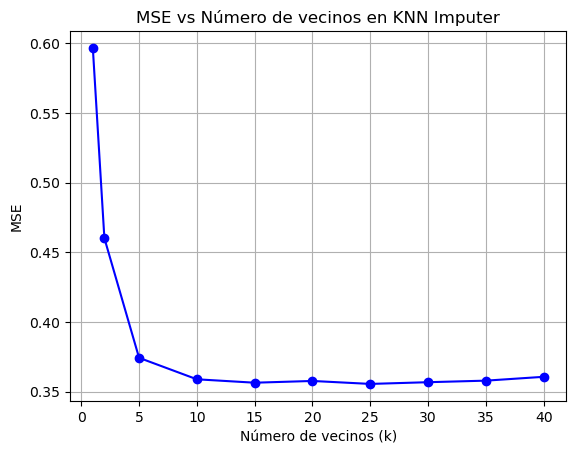

In [36]:
#Semilla para reproducibilidad
np.random.seed(seed = 2003)

#Valores de k a probar
k_valores = [1,2,5,10,15,20,25,30,35,40]
dicc_mse, list_mse = optimizar_k_vecinos(k_valores, centro)

Dados los resultados, se utilizara un valor de $k = 10$

In [37]:
k_vecinos = 10

#### Imputacion

In [38]:
def imputar_knn(df, k, scaler = StandardScaler()):
    
    # separar columna de fecha
    fecha = df['date']
    data = df.drop(columns = ['date'])
    
    # escalar datos
    data_scaled = scaler.fit_transform(data)
    
    # Imputar datos con KNNImputer
    imputer = KNNImputer(n_neighbors = k)
    data_imputed_scaled = imputer.fit_transform(data_scaled)
    
    # Desescalar los datos imputados
    data_imputed_descaled = pd.DataFrame(scaler.inverse_transform(data_imputed_scaled), columns = data.columns)
    
    # Juntar columna de fecha
    clean_df = pd.concat([fecha, data_imputed_descaled], axis=1)
    
    return clean_df

In [54]:
clean_centro = imputar_knn(centro, k = k_vecinos)

In [66]:
clean_centro

,date,CO,NO,NO2,NOX,O3,PM10,PM2.5,PRS,RAINF,RH,SO2,SR,TOUT,WSR,WDR
0,2022-01-01 00:00:00,2.60,3.50,44.90,48.50,15.0,134.0,91.00,705.5,0.0,46.0,5.3,0.000,21.37,3.4,267.0
1,2022-01-01 01:00:00,2.23,2.90,32.90,36.00,19.0,141.0,112.61,705.2,0.0,48.0,6.1,0.000,20.83,3.3,259.0
2,2022-01-01 02:00:00,1.99,2.90,27.60,30.70,21.0,117.0,92.46,705.1,0.0,46.0,5.8,0.000,20.52,5.9,233.0
3,2022-01-01 03:00:00,2.03,18.56,34.06,52.81,18.0,108.0,69.20,704.8,0.0,46.0,6.0,0.000,20.12,5.1,220.0
4,2022-01-01 04:00:00,1.86,12.09,34.58,46.86,20.0,106.0,68.03,704.8,0.0,46.0,5.6,0.000,19.85,4.7,244.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22625,2024-07-31 19:00:00,0.60,2.50,6.40,9.20,28.0,77.0,32.42,710.7,0.0,47.0,2.7,0.075,30.87,16.0,111.0
22626,2024-07-31 20:00:00,0.57,2.30,6.70,9.20,23.0,89.0,31.45,710.8,0.0,49.0,2.7,0.010,29.39,16.3,131.0
22627,2024-07-31 21:00:00,0.59,1.90,6.00,8.20,23.0,90.0,31.75,711.2,0.0,50.0,2.7,0.001,28.62,15.9,127.0
22628,2024-07-31 22:00:00,0.57,1.90,5.90,8.00,22.0,85.0,33.73,711.7,0.0,50.0,2.7,0.001,28.00,11.5,118.0


In [55]:
clean_centro.isna().sum().sum()

0

In [56]:
def porcentaje_imputados(df, clean_df):
    """ Calcula el porcentaje de los datos imputados en clean_df

    Args:
        df (pandas.dataframe): dataframe antes de la imputacion.
        clean_df (pandas.dataframe): dataframe despues de la imputacion

    Returns:
        float: porcentaje de datos imputados
    """
    porcentaje = (df.isna().sum().sum() / clean_df.count().sum()) * 100
    return porcentaje

In [67]:
p_imputados = porcentaje_imputados(centro, clean_centro)
print(f"Porcentaje de datos imputados {p_imputados:.4f}%")

Porcentaje de datos imputados 3.2485%


##### Corrección imputaciones incorrectas

In [58]:
print("Numero de filas en las que PM2.5 > PM10 en dataset imputado:", len(clean_centro.loc[clean_centro["PM2.5"] > clean_centro["PM10"]]))
print("Numero de filas en las que PM2.5 > PM10 en dataset original:", len(centro.loc[centro["PM2.5"] > centro["PM10"]]))

Numero de filas en las que PM2.5 > PM10 en dataset imputado: 198
Numero de filas en las que PM2.5 > PM10 en dataset original: 2


Dado que esto no puede ocurrir, y que casi todas estas instancias fueron errores de la imputación y no de los datos originales, crearemos una función para reemplazar estos datos erroneos de PM2.5 con la medicion de PM10 correspondiente.

In [59]:
def reemplazar_pm25_con_pm10(df):
    
    """ 
    Reemplaza los datos en la columna de PM2.5 con el
    dato de PM10 en filas donde PM2.5 > PM10

    Args:
        df (pandas.dataframe): dataset imputado

    Returns:
        pandas.dataframe: dataset imputado corregido
    """
    print("Datos PM2.5 reemplazados:", len(df.loc[df["PM2.5"] > df["PM10"]]))
    df.loc[df["PM2.5"] > df["PM10"], "PM2.5"] = df.loc[df["PM2.5"] > df["PM10"], "PM10"]
    return df

In [60]:
clean_centro = reemplazar_pm25_con_pm10(clean_centro)

Datos PM2.5 reemplazados: 198


In [61]:
# Verificacion
print("Numero de filas en las que PM2.5 > PM10 en dataset imputado:", len(clean_centro.loc[clean_centro["PM2.5"] > clean_centro["PM10"]]))

Numero de filas en las que PM2.5 > PM10 en dataset imputado: 0


### Comparacion entre datos originales e imputados

In [62]:
def calcular_diferencia_porcentual(df, clean_df):
    """
    Calcula diferencias porcentuales entre varias estadisticas
    descriptivas para dos datasets.

    Args:
        df (pandas.dataframe): dataset original
        clean_df (pandas.dataframe): dataset imputado

    Returns:
        pandas.dataframe: diferencias porcentuales de las estidisticas
        proporcionadas por el metodo pandas.describe()
    """
    for col in df.columns:
        if col != 'date':
            df[col] = df[col].astype(float)
    
    # Calculamos las estadísticas descriptivas
    stats_original = df.describe()
    stats_clean = clean_df.describe()
    
    diferencia_porcentual = ((stats_clean - stats_original) / stats_original) * 100
    # Evitar error por division entre 0
    diferencia_porcentual = np.where(stats_original == 0, 0, diferencia_porcentual)
    diferencia_porcentual_df = pd.DataFrame(diferencia_porcentual, 
                                            index=stats_original.index, 
                                            columns=stats_original.columns).round(4)
    return diferencia_porcentual_df

In [64]:
comparacion_centro = calcular_diferencia_porcentual(centro, clean_centro)
comparacion_centro

,CO,NO,NO2,NOX,O3,PM10,PM2.5,PRS,RAINF,RH,SO2,SR,TOUT,WSR,WDR
count,2.1440,5.9457,2.1993,2.1947,3.9886,2.4445,17.7542,2.0289,1.8773,2.5513,6.3340,0.7793,1.8681,1.8910,1.9645
mean,0.9228,-3.1629,0.2071,-0.1257,-0.9668,-0.4417,1.4205,0.0036,-1.1224,0.3313,-0.4858,0.0025,-0.3151,-0.3643,-0.5141
std,1.0593,-2.3646,-0.8741,-1.0045,-0.7616,-0.7060,-5.6709,-0.6316,-0.9246,-0.5844,-2.6047,-0.3836,-0.3204,-0.6050,-0.7574
min,0.0000,0.0000,-0.0000,-0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000,0.0000
25%,0.9524,-3.8462,0.0000,0.8929,0.0000,-0.1159,6.7958,0.0141,0.0000,2.7027,0.0000,0.0000,-0.8662,0.0000,2.1277
50%,1.3158,0.0000,2.0979,1.5789,0.0000,0.0000,9.7143,0.0000,0.0000,0.0000,2.5000,14.2857,-0.5476,0.0000,0.0000
75%,0.4630,-4.4336,-0.9868,-0.9231,-2.5000,0.0000,-3.2451,0.0140,0.0000,0.0000,0.0000,-1.3980,-0.2853,0.0000,-0.8475
max,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000


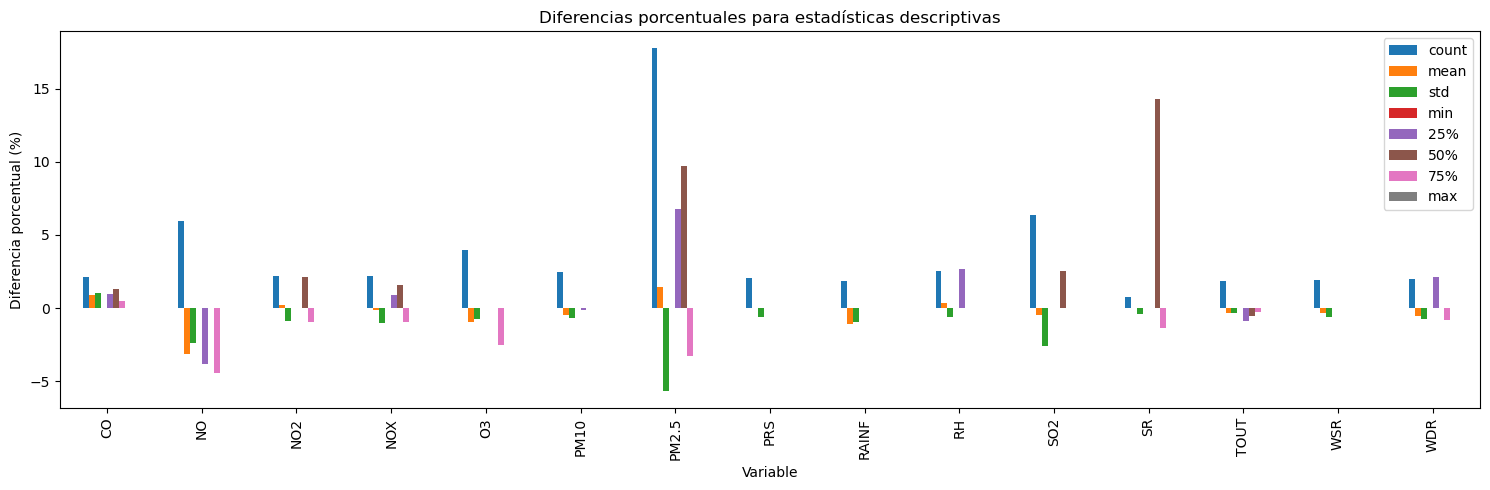

In [65]:
comparacion_centro.T.plot(kind="bar", figsize=(15, 5))
plt.title('Diferencias porcentuales para estadísticas descriptivas')
plt.xlabel('Variable')
plt.ylabel('Diferencia porcentual (%)')
plt.legend(title='')
plt.tight_layout()
plt.show()

### Guardar base de datos

In [68]:
clean_centro.to_csv("Datos_22_24_CENTRO_limpios.csv")